# Livrable 2 - Image processing

## The subject
The goal is to process a set of photographs by denoising them in order to make them better processable by Machine Learning algorithms. In this Jupyter notebook we will explain the pre-processing steps. The algorithms will rely on convolutional auto-encoders, and apply them to improve the image quality.

## Import

### Disable Tensorflow's warnings

In [18]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
RUN_DIR = 'data/'

In [19]:
import sys
import time
import tensorflow as tf
import numpy as np
from keras.utils import load_img, img_to_array
from matplotlib import pyplot as plt
from skimage.util import random_noise
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

## Global Variables

In [20]:
BATCH_SIZE: int = 16
IMG_HEIGHT: int = 228
IMG_WIDTH: int = 228
EPOCHS: int = 100
ZIP_PATH: str = 'https://raw.githubusercontent.com/Stan-fld/auto_encoder_data/main/data_ae.zip'
DATASET_PATH: str = RUN_DIR + 'data_ae'

## Progress bar

In [21]:
def progressbar(it, prefix="", size=60, file=sys.stdout):
    count = len(it)

    def show(j):
        x = int(size * j / count)
        file.write("%s[%s%s] %i/%i\r" % (prefix, "#" * x, "." * (size - x), j, count))
        file.flush()
        file.write("\n")

    show(0)
    for i, item in enumerate(it):
        yield item
        show(i + 1)
    file.flush()

## Load dataset

### Import dataset from github

In [22]:
http_response = urlopen(ZIP_PATH)
zipfile = ZipFile(BytesIO(http_response.read()))
zipfile.extractall(path=f'{RUN_DIR}data_ae')

### Normal datasets

In [23]:
# def get_images_as_array(folder_dir, name):
#     images = []
#     for img in progressbar(os.listdir(folder_dir), f'Generate dataset {name} : ', 50):
#         time.sleep(0.1)
#         if img.endswith(".jpg"):
#             image = load_img(f"{folder_dir}/{img}", target_size=(IMG_HEIGHT, IMG_WIDTH))
#             images.append(img_to_array(image))
#     return np.array(images) / 255
# # Train
# train_data = get_images_as_array(DATASET_PATH + '/training', 'training')
# # Validation
# val_data = get_images_as_array(DATASET_PATH + '/validation', 'validation')

# import cv2
# root_dir = 'data/data_ae/training/'
# train_data = []
# for img_path in os.listdir(root_dir):
#     img_array = cv2.imread(root_dir + img_path)
#     img_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
#     train_data.append(img_array)


# root_dir = 'data/data_ae/validation/'
# val_data = []
# for img_path in os.listdir(root_dir):
#     img_array = cv2.imread(root_dir + img_path)
#     img_array = cv2.resize(img_array, (IMG_HEIGHT, IMG_WIDTH))
#     val_data.append(img_array)

# train_data = np.array(train_data)
# train_data = train_data.astype('float32') / 255.

# val_data = np.array(val_data)
# val_data = val_data.astype('float32') / 255.


# Train
train_data = tf.keras.utils.image_dataset_from_directory('data/data_ae/training/',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Train
val_data = tf.keras.utils.image_dataset_from_directory('data/data_ae/validation/',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Transforming BatchDataset into array 
train_data = np.concatenate(list(train_data.map(lambda x, y: x))) 
val_data = np.concatenate(list(val_data.map(lambda x, y: x))) 
train_data = train_data.astype('float32') / 255. 
val_data = val_data.astype('float32') / 255.

Found 1506 files belonging to 2 classes.
Found 252 files belonging to 2 classes.


### Noisy datasets

In [24]:
# def noisy_gauss(images, name):
#     noisy_images = []
#     for image in progressbar(images, f'Generate dataset {name} : ', 50):
#         image = random_noise(image, mode='gaussian', mean=0, var=0.3)
#         image = random_noise(image, mode='s&p', amount=0.2, salt_vs_pepper=0.5)
#         image = random_noise(image, mode='poisson')
#         image = random_noise(image, mode='speckle', mean=0, var=0.1)
#         noisy_images.append(image)
#     return np.array(noisy_images)


# # Train noisy
# train_noisy_data = noisy_gauss(train_data.copy(), 'training noisy')

# # Validation noisy
# val_noisy_data = noisy_gauss(val_data.copy(), 'validation noisy')

# x_train = train_noisy_data
y_train = train_data

# x_val = val_noisy_data
y_val = val_data


noise_factor = 0.5
x_train = train_data + noise_factor * np.random.normal(size=train_data.shape) #A COMPLETER
x_val = val_data + noise_factor * np.random.normal(size=val_data.shape) #A COMPLETER

x_train = np.clip(x_train, 0., 1.)
x_val = np.clip(x_val, 0., 1.)

## Implementation of functions to display the images.

In [25]:
def display_single_image(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")


def display_image(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

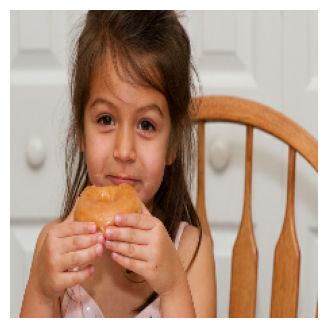

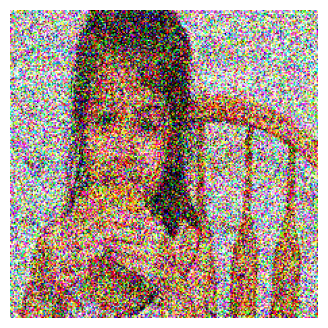

In [26]:
#Print an image of both datasets for testing
display_single_image(y_train[0])
display_single_image(x_train[0])

Training set


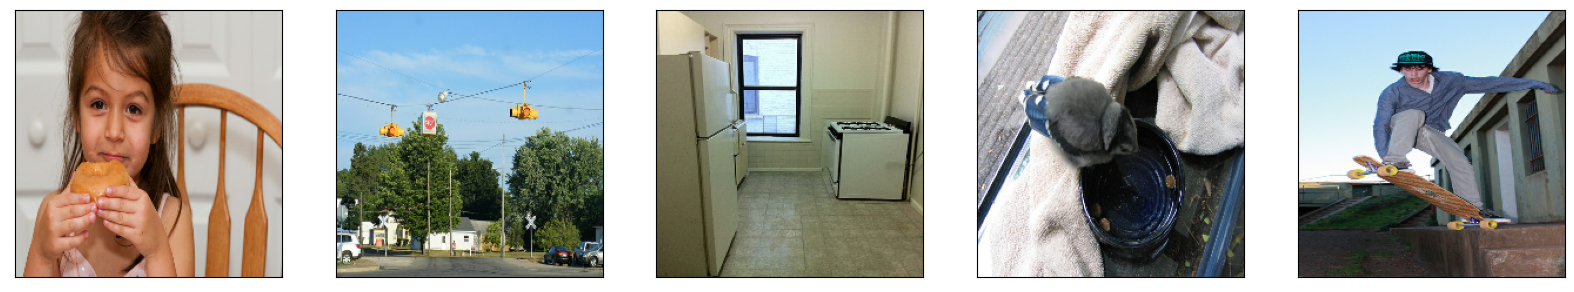

Noisy training set


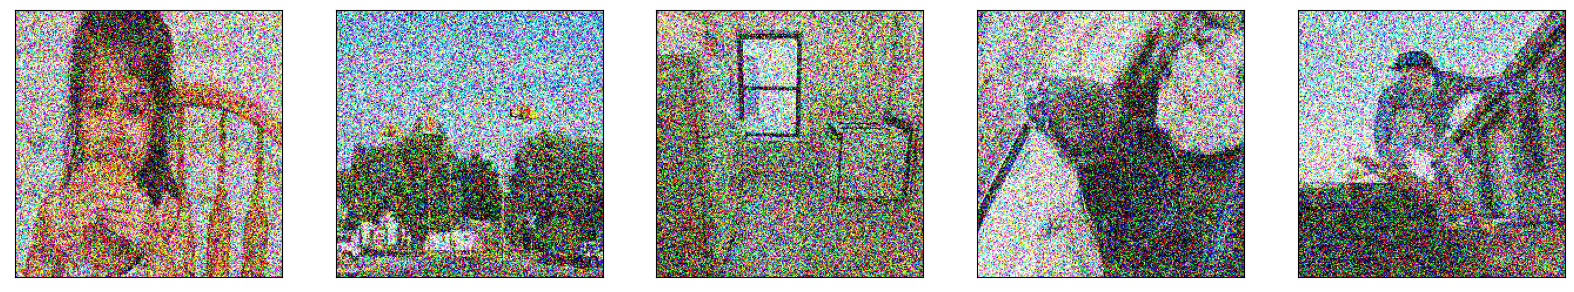

In [27]:
print("Training set")
display_image(y_train, 5)
print("Noisy training set")
display_image(x_train, 5)

# print("Validation Set")
# display_image(y_val, 5)
# print("Noisy validation set")
# display_image(x_val, 5)

## Encoder

In [28]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

encoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)

## Decoder

In [29]:
decoder = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(encoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)

decoder = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder)

## Auto encoder

In [30]:
auto_encoder = tf.keras.Model(inputs, decoder, name="auto_encoder")

auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

## Save the best model

In [31]:
filename = RUN_DIR + "models/best_model.h5"
callback_best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

## Train the model

In [32]:
# auto_encoder.summary()

with tf.device('/GPU:0'):
    history = auto_encoder.fit(x_train, y_train,
                               batch_size=BATCH_SIZE,
                               epochs=EPOCHS,
                               verbose=1,
                               shuffle=True,
                               validation_data=(x_val, y_val),
                               callbacks=[callback_best_model]
                               )

Epoch 1/100
95/95 [==============================] - 8s 72ms/step - loss: 0.5634 - val_loss: 0.5371
Epoch 2/100
95/95 [==============================] - 6s 59ms/step - loss: 0.5331 - val_loss: 0.5328
Epoch 3/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5306 - val_loss: 0.5325
Epoch 4/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5291 - val_loss: 0.5293
Epoch 5/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5276 - val_loss: 0.5289
Epoch 6/100
95/95 [==============================] - 6s 59ms/step - loss: 0.5269 - val_loss: 0.5289
Epoch 7/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5267 - val_loss: 0.5284
Epoch 8/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5259 - val_loss: 0.5283
Epoch 9/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5255 - val_loss: 0.5275
Epoch 10/100
95/95 [==============================] - 6s 60ms/step - loss: 0.5251 - val_loss: 0.5277

## Loss curve

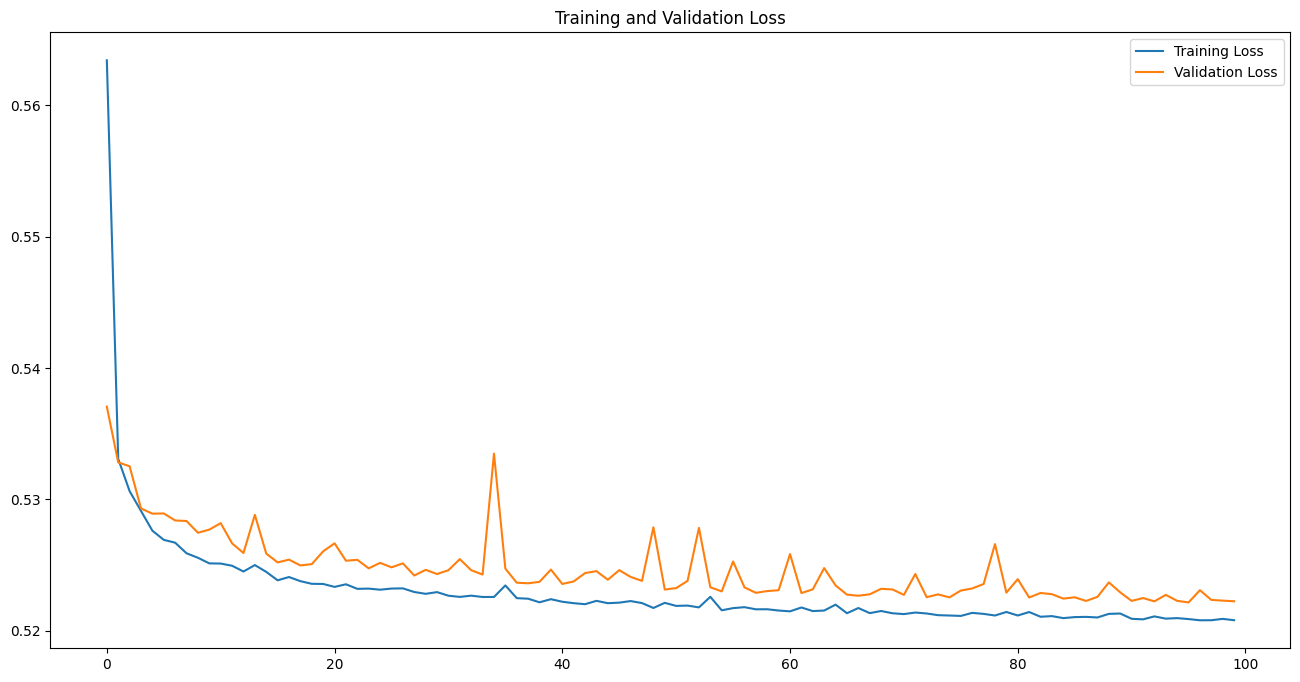

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(16, 8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Output

8/8 [==============================] - 1s 88ms/step


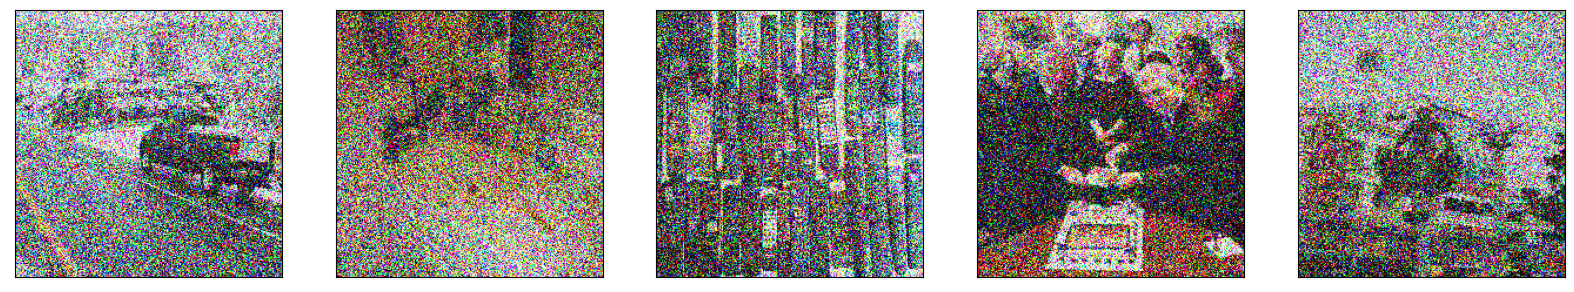

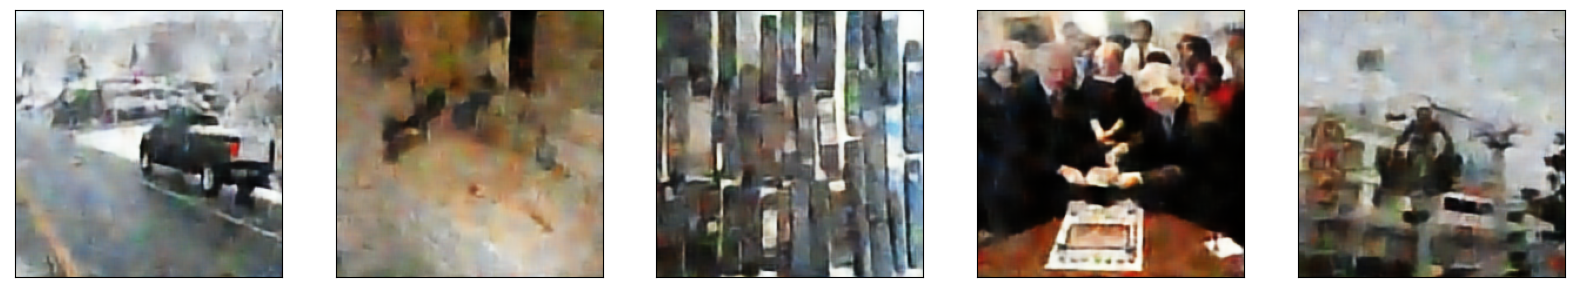

In [34]:
decoded_imgs = auto_encoder.predict(x_val)
display_image(x_val, n=5)
display_image(decoded_imgs, n=5)

In [38]:
import datetime
import pandas as pd

date:datetime = datetime.datetime.now().strftime("%m.%d.%Y_%H:%M:%S")
model_dir:str = f"models/autoenc_{date}"
auto_encoder.save(model_dir)
f = open(f"{model_dir}/model_summary.txt", "a")
auto_encoder.summary(print_fn=lambda x: f.write(x + '\n'))
f.close()

f = open(f"{model_dir}/model_history.csv", "a")
f.write(pd.DataFrame.from_dict(history.history).to_csv(index=False))
f.close()

INFO:tensorflow:Assets written to: models/autoenc_10.19.2022_11:22:43/assets


INFO:tensorflow:Assets written to: models/autoenc_10.19.2022_11:22:43/assets
